<a href="https://colab.research.google.com/github/sakarla/Machine-Learning-for-Architecs/blob/main/week%208_Computer%20Vision/code/week8_som_nn_classification_simpler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  What We’ll Learn Today?

This notebook shows how we can use AI to:
- Group similar building images using **Self-Organizing Maps (SOM)**
- Train a neural network to classify them into 2 types (Binary Classification)

Architecture students can use this to:
- Understand how buildings or urban features can be clustered
- Train AI models on visual data (like building facades or roofs)


# Mount Google Drive and Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install numpy pandas matplotlib minisom


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=dc9a6b8020d80d3bb79baa3b1d38d93f613aa61488a33c6454391d35a7ecd43e
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from PIL import Image
import ast
import tensorflow as tf


# Define Paths and Load Data

In [ ]:
# Define paths
image_dir = '/content/drive/MyDrive/Colab Notebooks/ML_for_Architects/collecting data/myproject/myproject/IMAGE/downloaded_images'
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/ML_for_Architects/collecting data/myproject/myproject/IMAGE/image_features_vgg16.csv'

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Extract filenames and convert stringified lists to actual lists
filenames = data.iloc[:, 0].values
features = data.iloc[:, 1].apply(ast.literal_eval).tolist()
features = np.array(features)


In [ ]:
print("Loaded", len(features), "image feature vectors")
print("Each feature vector shape:", features[0][:5], "... (truncated)")

Loaded 703 image feature vectors
Each feature vector shape: [0. 0. 0. 0. 0.] ... (truncated)


# Initialize and Train Self-Organizing Map (SOM)

In [ ]:
# Set parameters for SOM
m = 5
map_size = (m, m)
input_len = features.shape[1]
sigma = 1.0
learning_rate = 0.5
num_epochs = 100

# Initialize SOM
som = MiniSom(map_size[0], map_size[1], input_len, sigma=sigma, learning_rate=learning_rate,
              activation_distance='cosine', random_seed=42)
som.random_weights_init(features)

# Train SOM
som.train_random(features, len(features), verbose=True)


 [ 703 / 703 ] 100% - 0:00:00 left 
 quantization error: 612.837106310929


# Determine BMUs and Visualize SOM Clusters

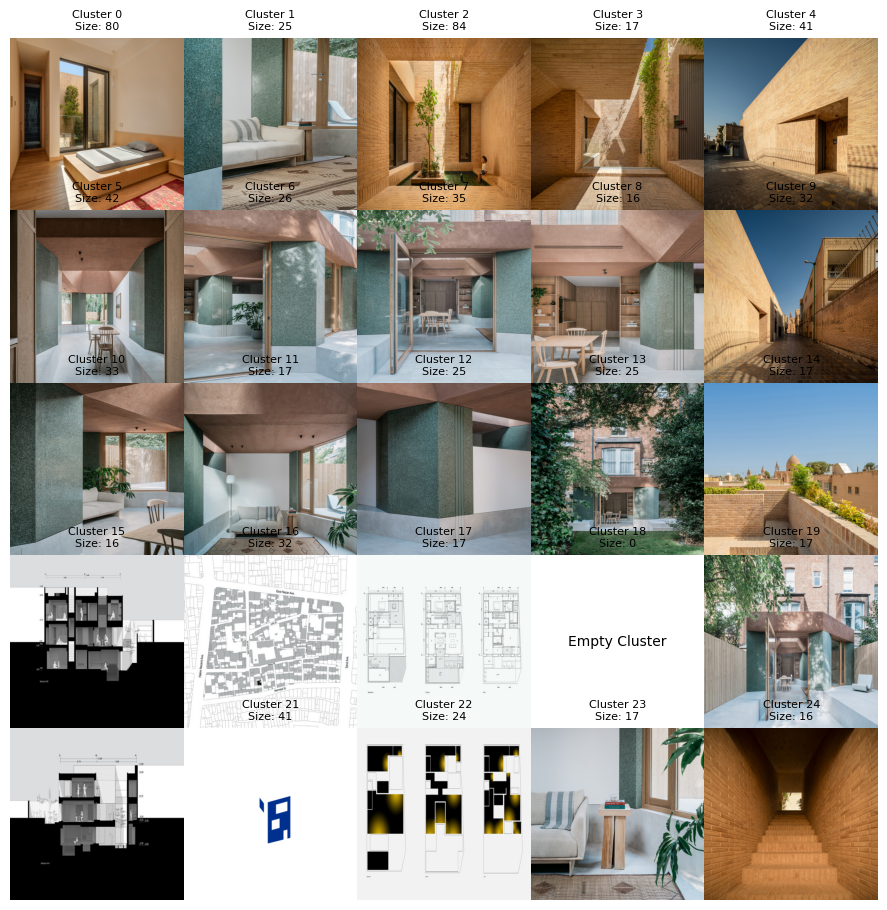

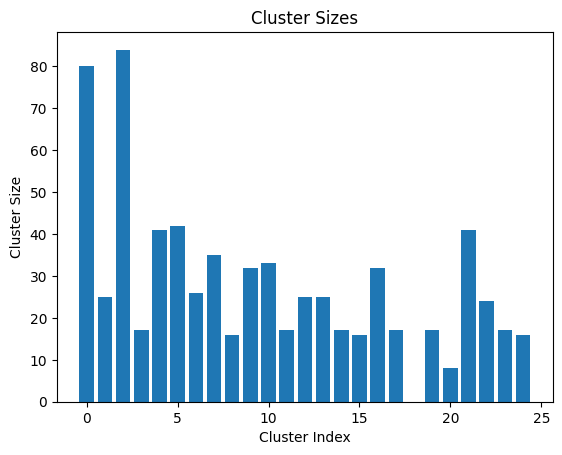

In [ ]:
# Determine best matching units for each image
bmu_indices = np.array([som.winner(x) for x in features])

# Define grid size
dpi = 100
subplot_size = 224
figsize = (m * subplot_size / dpi, m * subplot_size / dpi)

# Create a figure with m x m subplots
fig, axes = plt.subplots(m, m, figsize=figsize)

# Create a list to keep track of cluster sizes
cluster_sizes = []

# Plot each image in the grid
for i in range(m):
    for j in range(m):
        index = i * m + j
        bmu_images_indices = [idx for idx, bmu in enumerate(bmu_indices) if tuple(bmu) == (i, j)]
        cluster_sizes.append(len(bmu_images_indices))

        if len(bmu_images_indices) > 0:
            img_index = bmu_images_indices[0]
            img = Image.open(image_dir + '/' + filenames[img_index])
            axes[i, j].imshow(img, aspect='auto')
        else:
            axes[i, j].text(0.5, 0.5, "Empty Cluster", ha="center", va="center")

        axes[i, j].set_title(f'Cluster {index}\nSize: {len(bmu_images_indices)}', fontsize=8)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['left'].set_visible(False)
        axes[i, j].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('grid_som_5x5_no_borders.png', bbox_inches='tight', pad_inches=0)
plt.show()

# Visualize cluster sizes as a bar chart
plt.figure()
plt.bar(range(m * m), cluster_sizes)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes')
plt.savefig('cluster_sizes.png')
plt.show()


# Assign Cluster Labels to Images and Save to CSV

In [ ]:
# Assign cluster labels to images
data_for_csv = []

for idx, bmu in enumerate(bmu_indices):
    image_path = os.path.join(image_dir, filenames[idx])
    cluster_label = bmu[0] * m + bmu[1]
    data_for_csv.append([image_path, cluster_label])

df = pd.DataFrame(data_for_csv, columns=["image_path", "cluster_label"])
csv_output_path = "/content/drive/MyDrive/Colab Notebooks/ML_for_Architects/collecting data/myproject/myproject/IMAGE/clustered_images_whole_data.csv"
df.to_csv(csv_output_path, index=False)
print(f"CSV file saved at: {csv_output_path}")


CSV file saved at: /content/drive/MyDrive/Colab Notebooks/ML_for_Architects/collecting data/myproject/myproject/IMAGE/clustered_images_whole_data.csv


# Filter Data for Binary Classification

In [ ]:
# Load the CSV with image paths and numeric labels
df = pd.read_csv(csv_output_path)

# Choose two specific labels for binary classification
label_1 = 2
label_2 = 5

# Filter the dataframe to include only the two selected labels
binary_df = df[df['cluster_label'].isin([label_1, label_2])]

# Relabel the two labels as 0 and 1 for binary classification
binary_df['binary_label'] = binary_df['cluster_label'].apply(lambda x: 0 if x == label_1 else 1)
print(binary_df.head())


                                           image_path  cluster_label  \
3   /content/drive/MyDrive/Colab Notebooks/ML_for_...              2   
11  /content/drive/MyDrive/Colab Notebooks/ML_for_...              5   
14  /content/drive/MyDrive/Colab Notebooks/ML_for_...              2   
15  /content/drive/MyDrive/Colab Notebooks/ML_for_...              2   
18  /content/drive/MyDrive/Colab Notebooks/ML_for_...              5   

    binary_label  
3              0  
11             1  
14             0  
15             0  
18             1  


/tmp/ipython-input-10-1044797356.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['binary_label'] = binary_df['cluster_label'].apply(lambda x: 0 if x == label_1 else 1)


# Display One Image from Each Class

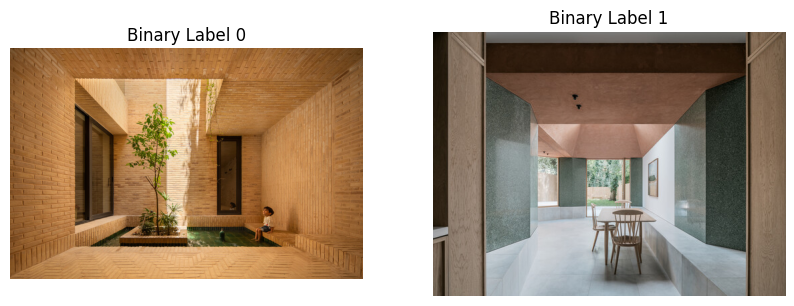

In [ ]:
img_path_label_0 = binary_df[binary_df['binary_label'] == 0].iloc[0]['image_path']
img_path_label_1 = binary_df[binary_df['binary_label'] == 1].iloc[0]['image_path']

img_0 = Image.open(img_path_label_0)
img_1 = Image.open(img_path_label_1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_0)
axs[0].set_title('Binary Label 0')
axs[0].axis('off')

axs[1].imshow(img_1)
axs[1].set_title('Binary Label 1')
axs[1].axis('off')
plt.show()


# Load Images and Prepare Data for Classification

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = load_img(row['image_path'], target_size=target_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row['binary_label'])
    return np.array(images), np.array(labels)

X, y = load_and_preprocess_images(binary_df)


# Train a Binary Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def build_binary_classifier(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

binary_classifier = build_binary_classifier(X.shape[1:])
history = binary_classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.6695 - loss: 29.7077 - val_accuracy: 0.6538 - val_loss: 14.5398
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.6576 - loss: 19.9609 - val_accuracy: 0.6538 - val_loss: 10.4179
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7903 - loss: 4.0743 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.9585 - loss: 0.4414 - val_accuracy: 0.8462 - val_loss: 0.4487
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8181 - loss: 1.0663 - val_accuracy: 1.0000 - val_loss: 1.3166e-04
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9513 - loss: 0.2112 - val_accuracy: 0.8462 - val_loss: 0.9373
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9197 - loss: 0.4680 - val_accuracy: 1.0000 - val_loss: 4.2707e-09
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 1.0000 - loss: 1.6614e-08 - val_accuracy: 1.

# Plot Training History

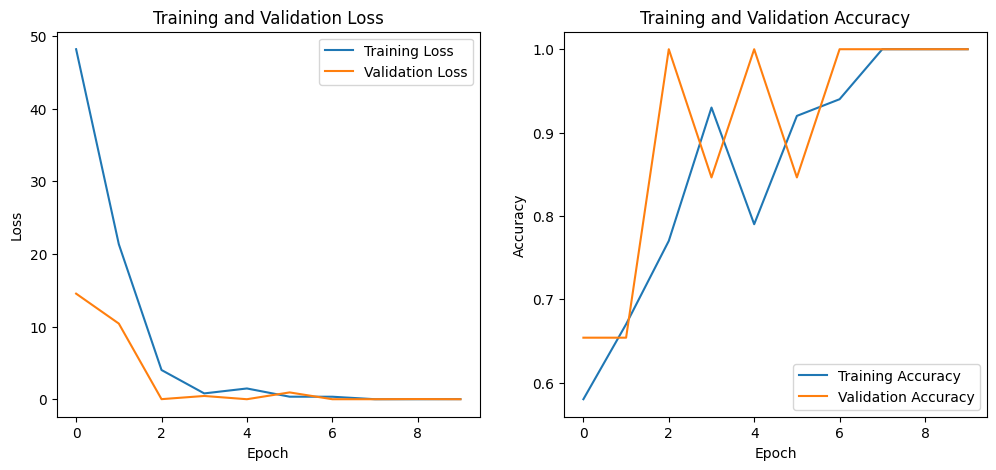

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)


# Evaluate Model and Display Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 7.2397e-04
Validation Loss: 0.0007239655242301524, Validation Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


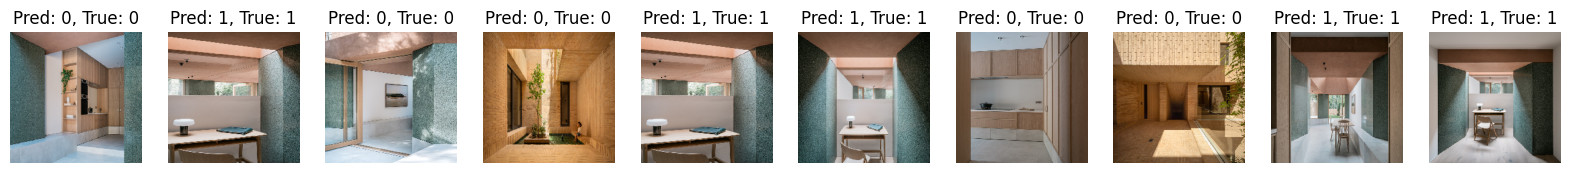

In [ ]:
loss, accuracy = binary_classifier.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for idx in range(10):
    img = X_val[idx]
    prediction = binary_classifier.predict(np.expand_dims(img, axis=0))[0][0]
    predicted_label = 1 if prediction > 0.5 else 0
    axs[idx].imshow(img)
    axs[idx].set_title(f'Pred: {predicted_label}, True: {y_val[idx]}')
    axs[idx].axis('off')
plt.show()
